In [86]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

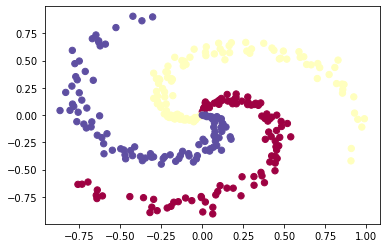

In [87]:
# Code for creating a spiral dataset from CS231n

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
x = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [89]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [90]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 64)

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [91]:
y_train.shape

torch.Size([240])

In [92]:
class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_features):
    super().__init__()

    self.network = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_features),
        nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features = hidden_features),
        nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features = output_features)
    )

  def forward(self, x):
    return self.network(x)


spiral = SpiralModel(input_features = D, output_features = K, hidden_features = 10).to(device)
spiral


SpiralModel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [93]:
# loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = spiral.parameters(), lr = 0.01)

In [94]:
!pip -q install torchmetrics

In [95]:
from torchmetrics import Accuracy

torchmetrics_acc = Accuracy(task = 'multiclass', num_classes = 3).to(device)

In [96]:
# Training loop
epoches = 1000
torch.manual_seed(64)
torch.cuda.manual_seed(64)

for epoch in range(epoches):
  # train
  spiral.train()

  # 1. Forward
  y_logits = spiral(x_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  # 2. loss
  loss = loss_fn(y_logits, y_train)
  acc = torchmetrics_acc(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Backward
  loss.backward()

  # 5.optimizer step
  optimizer.step()

  # test
  spiral.eval()

  with torch.inference_mode():
    # 1. Forward
    test_logits = spiral(x_test).squeeze()
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    # 2. loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = torchmetrics_acc(test_pred, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} | acc: {acc} | test_acc: {test_acc}") 

Epoch: 0 | Loss: 1.0948479175567627 | Test Loss: 1.1028391122817993 | acc: 0.34583333134651184 | test_acc: 0.28333333134651184
Epoch: 100 | Loss: 0.35079023241996765 | Test Loss: 0.4333818554878235 | acc: 0.8458333611488342 | test_acc: 0.75
Epoch: 200 | Loss: 0.07733692228794098 | Test Loss: 0.10198010504245758 | acc: 0.987500011920929 | test_acc: 0.9833333492279053
Epoch: 300 | Loss: 0.04195956885814667 | Test Loss: 0.037815749645233154 | acc: 0.9916666746139526 | test_acc: 1.0
Epoch: 400 | Loss: 0.031507458537817 | Test Loss: 0.019221069291234016 | acc: 0.9916666746139526 | test_acc: 1.0
Epoch: 500 | Loss: 0.026655856519937515 | Test Loss: 0.011330178007483482 | acc: 0.9916666746139526 | test_acc: 1.0
Epoch: 600 | Loss: 0.02375124953687191 | Test Loss: 0.007008783519268036 | acc: 0.9916666746139526 | test_acc: 1.0
Epoch: 700 | Loss: 0.021532749757170677 | Test Loss: 0.00505359610542655 | acc: 0.9916666746139526 | test_acc: 1.0
Epoch: 800 | Loss: 0.019923683255910873 | Test Loss: 0.00

In [97]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file exists, skip download")
else:
  print("Download file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

file exists, skip download


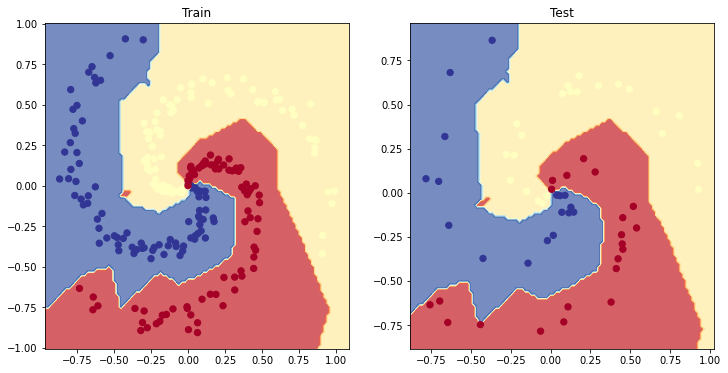

In [98]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(spiral, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(spiral, x_test, y_test)

In [99]:
from pathlib import Path

FOLDER = Path("models")
FOLDER.mkdir(parents = True, exist_ok = True)

FILE = "Multi_Class.pth"
FILE_PATH = FOLDER / FILE

torch.save(obj = spiral.state_dict(), f = FILE_PATH)

In [102]:
# load file
spiral_load = SpiralModel(input_features = 2, output_features = 3, hidden_features = 10).to(device)

spiral_load.load_state_dict(torch.load(f = FILE_PATH))

with torch.inference_mode():
  load_logits = spiral_load(x_test)
  load_pred = torch.softmax(load_logits, dim = 1).argmax(dim = 1)

load_pred == test_pred

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True],
       device='cuda:0')